In [1]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO

# standard import
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# nf imports
from models.conditional_affine_coupling_nf import ConditionalNormalizingFlow
from models._utils import RotatingTwoMoonsConditionalSampler

In [2]:
plt.style.use("ggplot")

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]

This Notebook implements a (Conditional) Normalizing Flow (as in RealNVP) on a RotatingTwoMoons Dataset. The conditioning variable (i.e. context variable) represents an indicator function of the rotation applied to the Two Moons.

### Data 

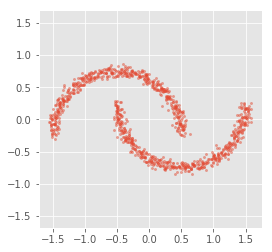

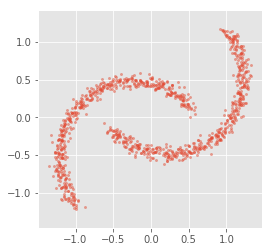

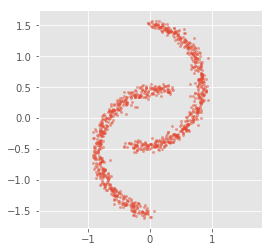

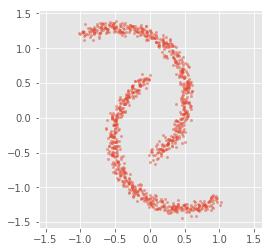

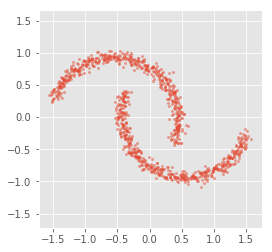

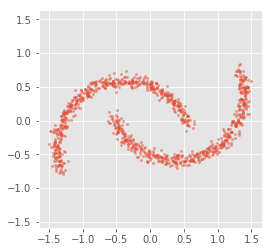

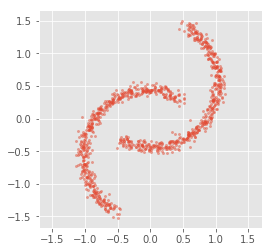

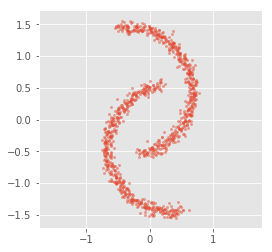

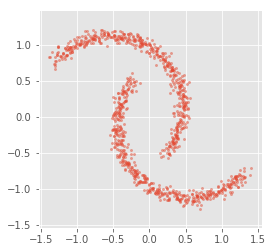

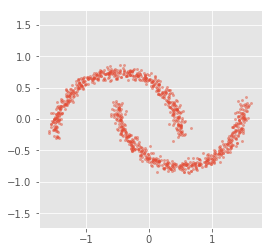

In [4]:
# Generate 10 rotated versions of the TwoMoons dataset and visualize
_X_H = torch.zeros((10, 1024, 2))
_H = torch.zeros((10, 1024, 1))
pis = np.linspace(0, 2, 10)
for i, pi in enumerate(pis):
    cond_two_moons = RotatingTwoMoonsConditionalSampler()
    x, y = cond_two_moons.conditioned_sample(1024, theta=torch.tensor([np.pi*pi]))
    plt.figure(figsize=(4,4))
    plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
    plt.axis('equal')
    plt.show()
    _X_H[i] = x
    _H[i] = torch.zeros(1024,1) + i

In [5]:
# build data-iterator
H = _H.view(-1,1)
X_H = _X_H.view(-1,2)
dataset = Dataset(H, X_H)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2000,
                        shuffle=True, num_workers=0)

In [24]:
# Build NF model
cnf = ConditionalNormalizingFlow(input_dim=2, split_dim=1, context_dim=1, hidden_dim=64, num_layers=5, flow_length=16, 
                    use_cuda=False)

In [28]:
# Build SVI object
optimizer = pyro.optim.Adam({"lr": 0.0001})
svi = SVI(cnf.model, cnf.guide, optimizer, Trace_ELBO(num_particles=1))

In [29]:
print("number of params: ", sum(p.numel() for p in nn.ModuleList(cnf.transforms).parameters()))

number of params:  271392


ELBO: 2967.13:   3%|▎         | 29/1000 [01:12<40:15,  2.49s/it]


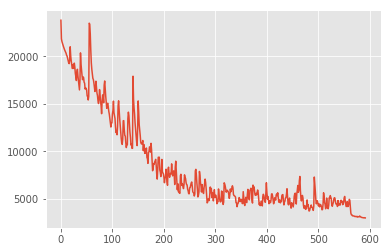

In [30]:
num_epochs = 1000
losses = []
pyro.clear_param_store()
epochs = tqdm.trange(num_epochs)

for epoch in epochs:
    try:
        running_loss = 0
        for x_batch, y_batch in dataloader:
            if cnf.use_cuda:
                y_batch, x_batch = y_batch.cuda(), x_batch.cuda()
            loss = svi.step(y_batch, x_batch)
            running_loss += float(loss)
            del x_batch, y_batch
            del loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
        # Checkpoint model
#         if running_loss <= best_loss:
#             torch.save(cnf, "cnf_torch_save_run")
        del running_loss
    except KeyboardInterrupt:
        plt.plot(losses);
        break

In [27]:
# load model from checkpoint
# cnf = torch.load("cnf_torch_save_run")

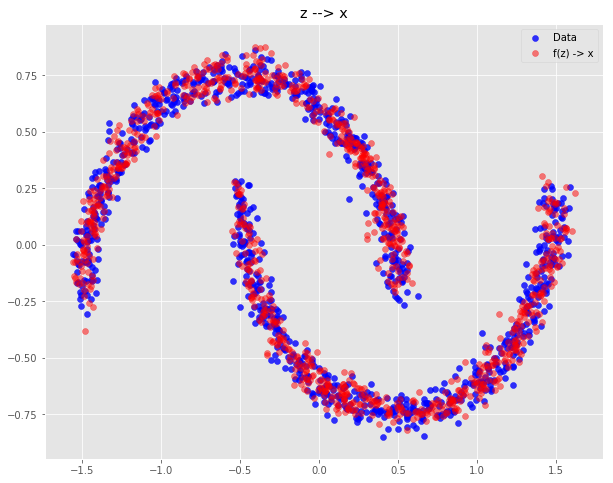

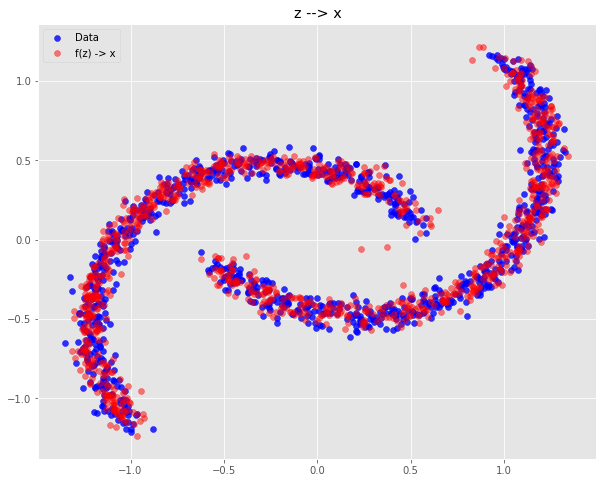

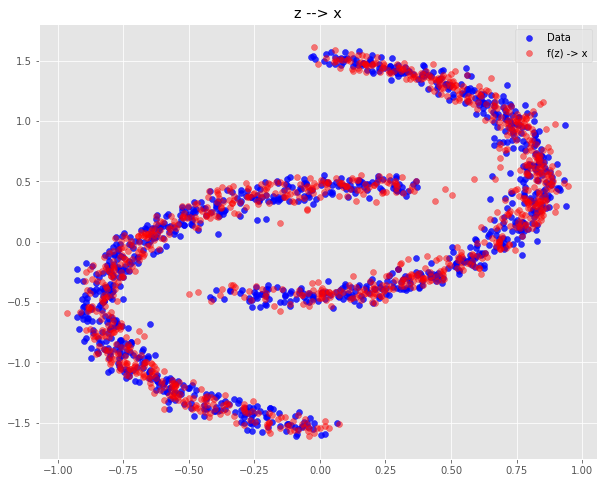

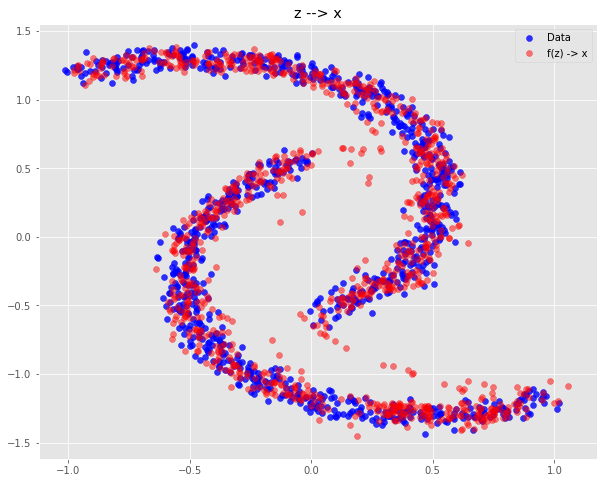

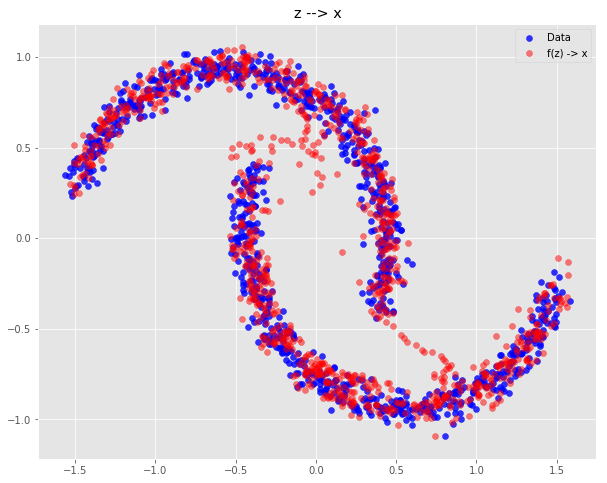

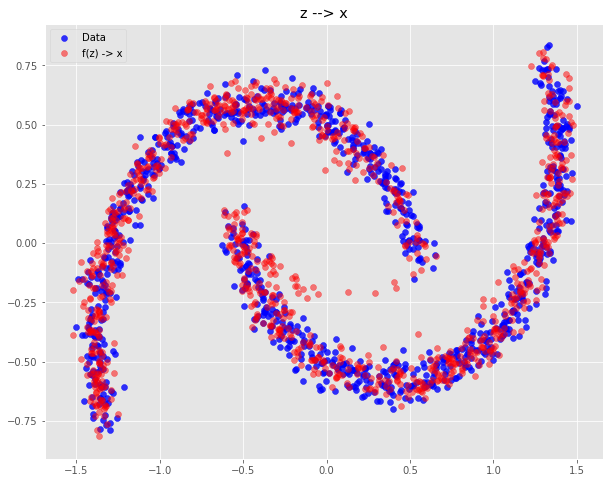

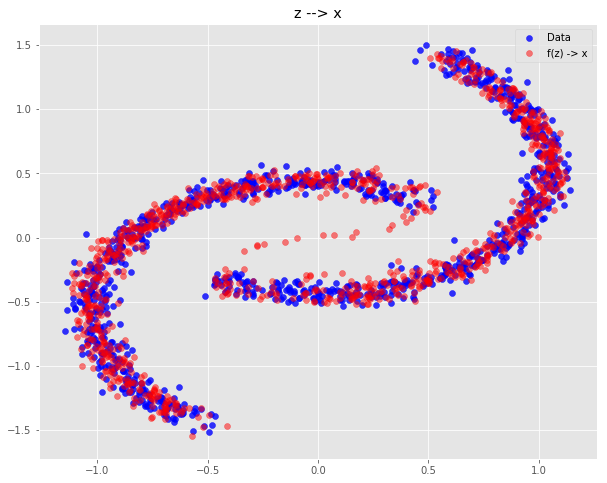

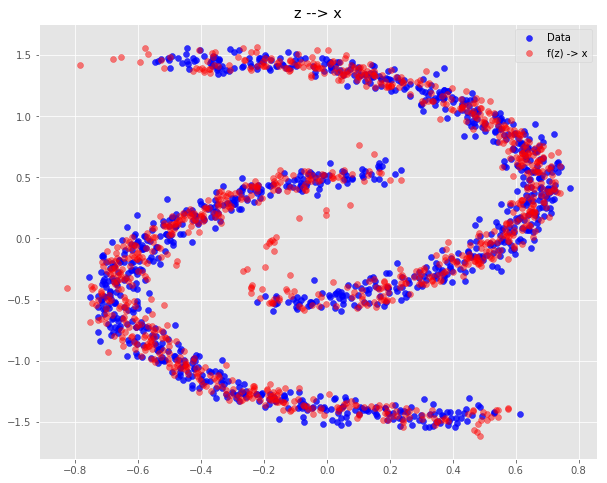

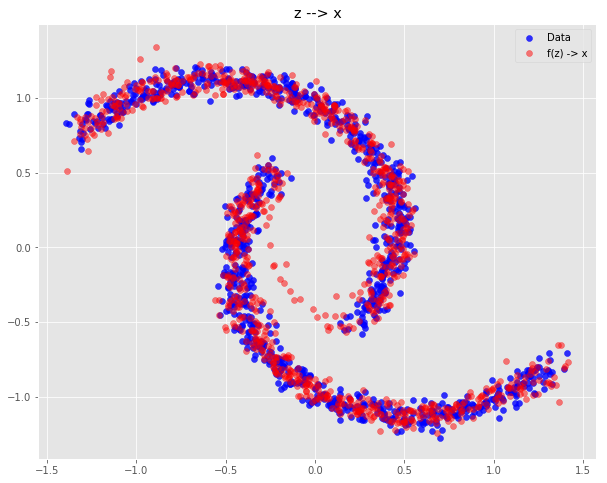

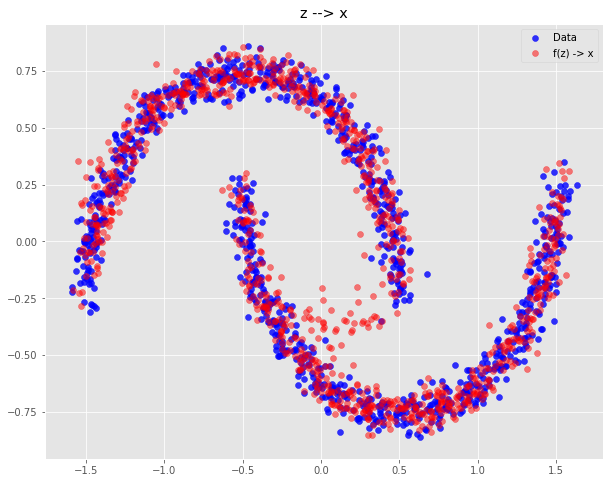

In [33]:
# Sample from trained NF (generative direction z -> x)
for i in range(10):
    samples = cnf.sample(num_samples=1000, H=torch.zeros(1000,1)+i).detach()
    fig = plt.figure(figsize=(10,8))
    plt.scatter(_X_H[i, :, 0], _X_H[i, :, 1], c="b", label="Data", alpha=0.8)
    plt.scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) -> x")
    plt.title("z --> x")
    plt.legend()

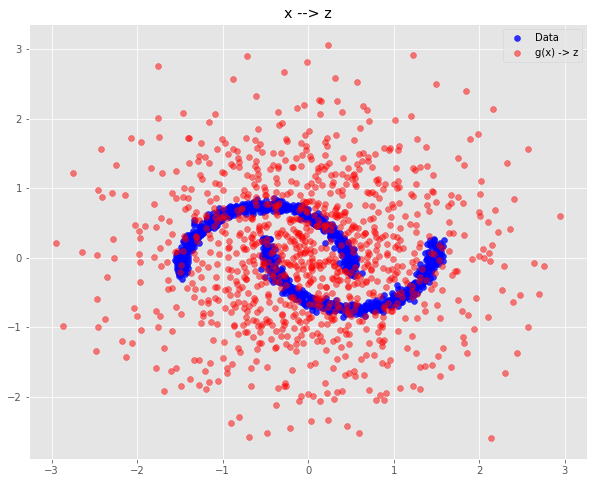

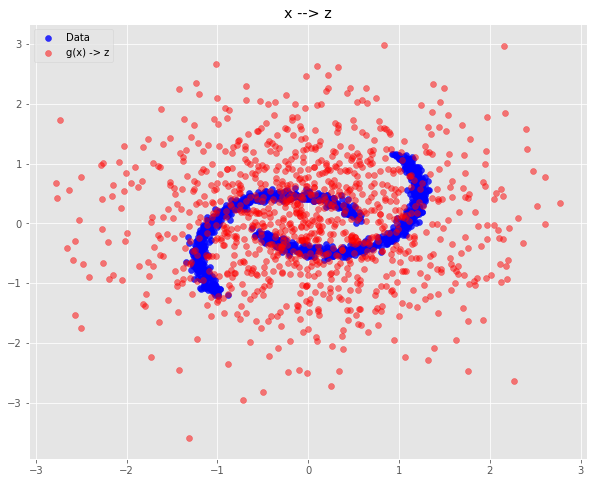

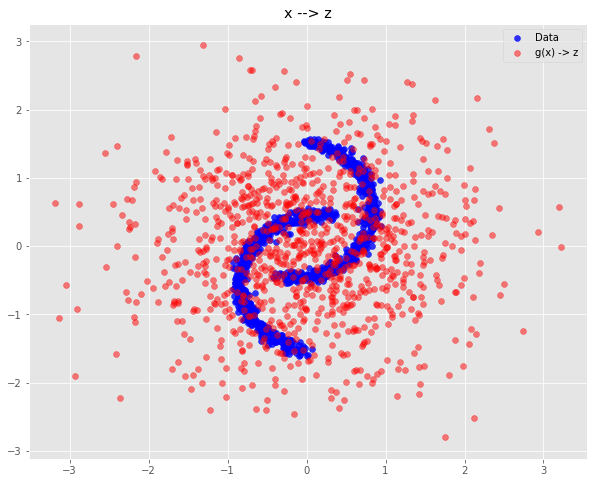

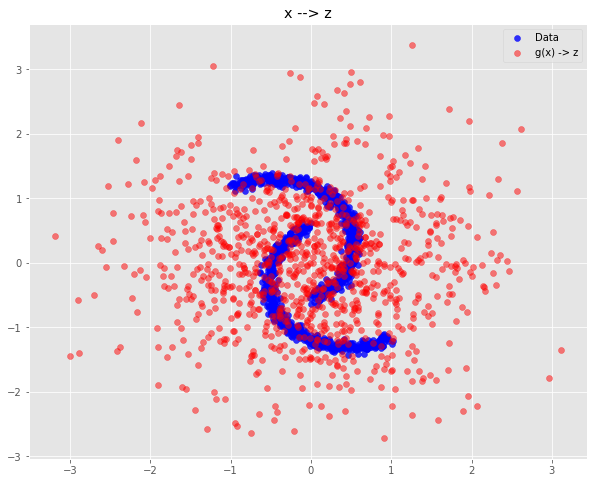

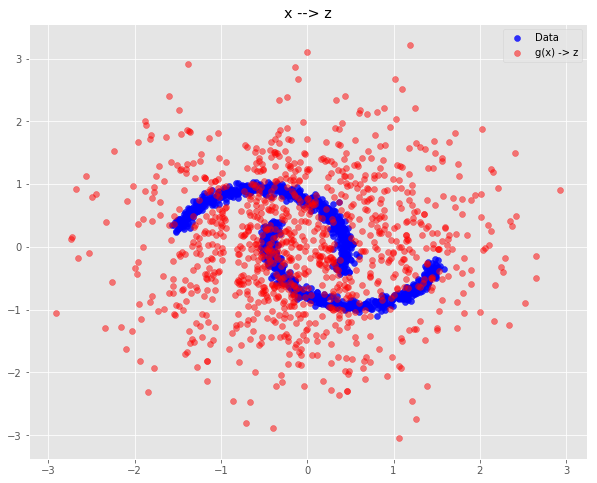

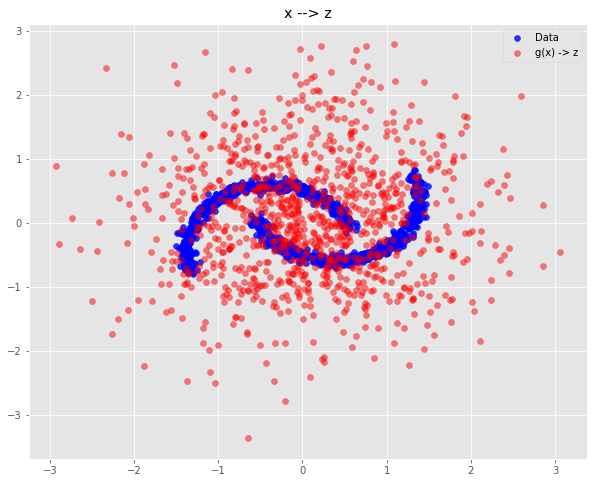

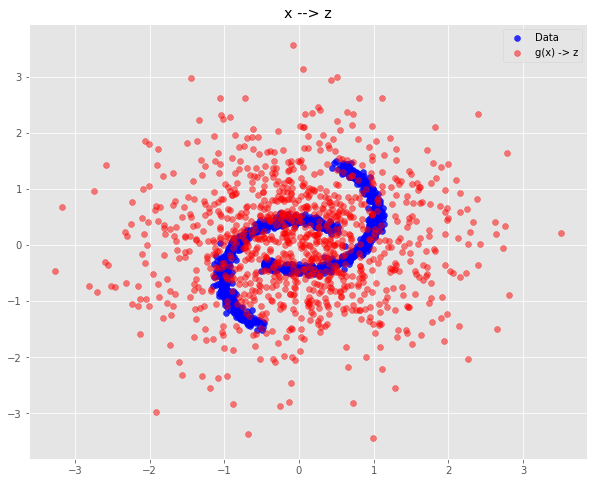

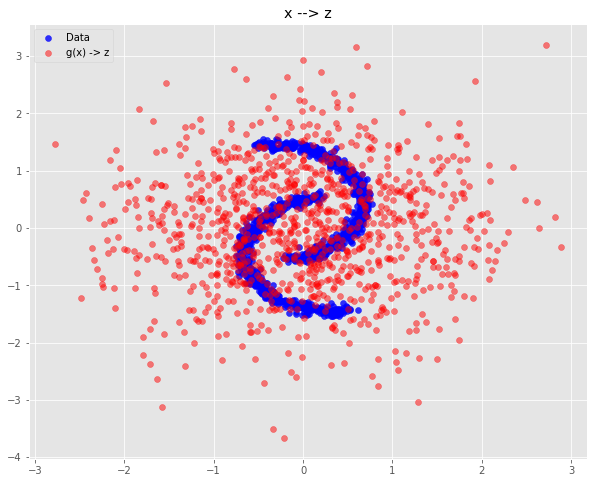

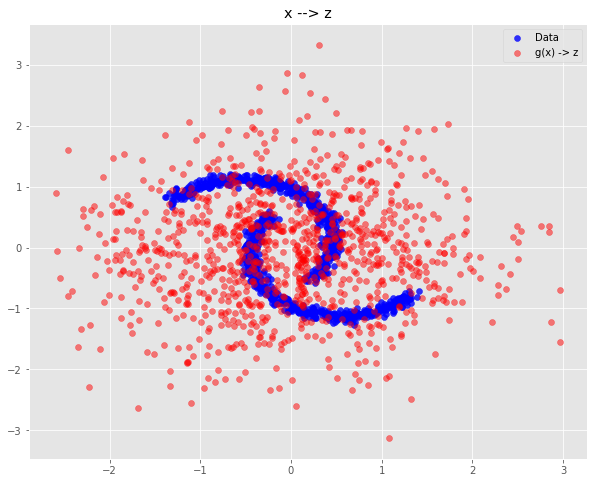

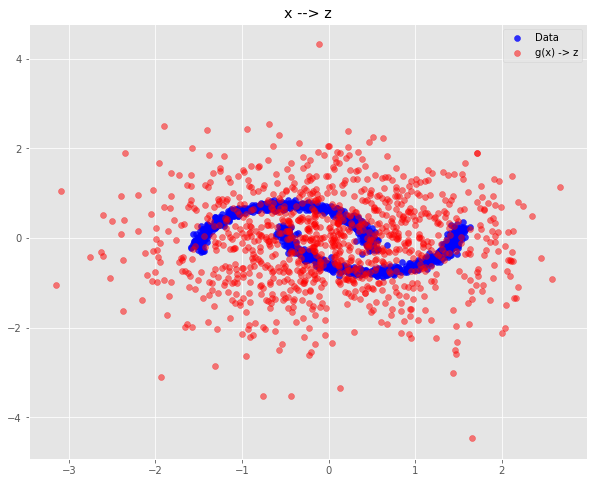

In [34]:
# Run data backward through the flow (normalizing direction x -> z)
for i in range(10):
    z_prior = cnf.backward(x=_X_H[i].view(-1,2), H=torch.zeros(1024,1)+i)[1].detach()
    fig = plt.figure(figsize=(10,8))
    plt.scatter(_X_H[i].view(-1,2)[:, 0], _X_H[i].view(-1,2)[:, 1], c="b", label="Data", alpha=0.8)
    plt.scatter(z_prior[:, 0], z_prior[:, 1], c="r", alpha=0.5, label="g(x) -> z")
    plt.title("x --> z")
    plt.legend()
    plt.show()